### Capstone A - Clustering


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from os.path import isfile
import email
#import BeautifulSoup
from bs4 import BeautifulSoup
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import silhouette_score
import hdbscan
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn import metrics as mt
from sklearn.feature_extraction import text
from wordcloud import WordCloud
from scipy.sparse import hstack

import warnings
warnings.filterwarnings("ignore")

In [2]:
# location of emails
data_path = "/Users/ravis/Downloads/phishingdata"
# get all sub folders
sub_folders = [x[0] for x in os.walk(data_path) if x[0] != data_path]

In [3]:
sub_folders

['/Users/ravis/Downloads/phishingdata/testdata',
 '/Users/ravis/Downloads/phishingdata/testdata/apruvspam',
 '/Users/ravis/Downloads/phishingdata/testdata/apruvspam/spamfiles1',
 '/Users/ravis/Downloads/phishingdata/traindata',
 '/Users/ravis/Downloads/phishingdata/traindata/spam',
 '/Users/ravis/Downloads/phishingdata/traindata/hard_ham',
 '/Users/ravis/Downloads/phishingdata/traindata/spam_2',
 '/Users/ravis/Downloads/phishingdata/traindata/easy_ham',
 '/Users/ravis/Downloads/phishingdata/traindata/ravispam',
 '/Users/ravis/Downloads/phishingdata/traindata/easy_ham_2']

In [5]:
%%time
                   
# read all emails from all sub folders
mail_ty = []
text_ty = []
data = []
target = []
email_attachment = []
attachment = False
is_test_data = []

for folder in sub_folders:
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    for file in files:
        with open(f"{folder}/{file}", encoding="latin1") as f:
            #    with open(f"{folder}/{file}","r") as f:
            x = email.message_from_file(f)
          #  print(x)
    #    if (file != 'cmds'): 
    #        mail_data.append(lines)
            
        mail_type = x.get_content_type()
        text_type = x.get_content_charset()
        mail_ty.append(mail_type)
        text_ty.append(text_type)
        if re.search("spam", folder):
            target.append(1)
        else:
             target.append(0)
        
        if "testdata" in folder:
            is_test_data.append(1)
        else:
            is_test_data.append(0)
                               
        if mail_type == "text/html":
            if not (isinstance(x.get_payload(), str)) and x.get_payload().get('Content-Disposition'):
                dispositions = x.get_payload().get("Content-Disposition", None).strip().split(";")
                if bool(dispositions[0].lower() == "attachment"):
                    attachment = True
                else:
                    attachment = False
          
            tmp = BeautifulSoup(x.get_payload(), 'html.parser')
            tmp = tmp.text.replace("\n", " ")
            data.append(tmp)
        elif "multipart" in mail_type:
            attachment = False
            multipart_data = []
            for text in x.get_payload():                        
                if not isinstance(text, str): 
                    if text.get('Content-Disposition'):
                        dispositions = text.get("Content-Disposition", None).strip().split(";")
                        if bool(dispositions[0].lower() == "attachment"):
                            attachment = True
                            
                    if text.get_content_type() == "text/html":
                        tmp = BeautifulSoup(text.get_payload(), 'html.parser')
                        tmp = tmp.text.replace("\n", " ")
                        multipart_data.append(tmp)
                    elif text.get_content_type() == "text/plain":
                        multipart_data.append(text.get_payload()) 
                
            multipart_email = [''.join(str(item)) for item in multipart_data]
            data.append(multipart_email)
        else:
            if not (isinstance(x.get_payload(), str)) and x.get_payload().get('Content-Disposition'):
                dispositions = x.get_payload().get("Content-Disposition", None).strip().split(";")
                if bool(dispositions[0].lower() == "attachment"):
                    attachment = True
                else:
                    attachment = False
            data.append(x.get_payload()) 
            
        if attachment:
            email_attachment.append(1)
        else:
            email_attachment.append(0)
                        
                
# Reference: https://gaurav.kuwar.us/index.php/2017/10/09/extracting-files-from-raw-email-with-python/

CPU times: user 7.91 s, sys: 344 ms, total: 8.25 s
Wall time: 9.38 s


In [6]:
df = pd.DataFrame()

In [7]:
df["mail_types"] = mail_ty
df["text_types"] = text_ty

In [8]:
# Count of mail types           
df["mail_types"].value_counts()

text/plain                     7511
text/html                      1390
multipart/alternative           556
multipart/mixed                 192
multipart/signed                180
multipart/digest                 64
multipart/related                58
multipart/report                 19
multipart/encrypted               1
text/plain charset=us-ascii       1
Name: mail_types, dtype: int64

In [9]:
# Count of text types
df["text_types"].value_counts()

us-ascii           3427
iso-8859-1         1960
windows-1252        197
utf-8               134
iso-8859-15         104
default              15
iso-8859-2           13
windows-1251         13
iso-2022-jp          12
gb2312               11
default_charset      10
ks_c_5601-1987        7
koi8-r                6
windows-1254          6
iso-8859-9            4
ascii                 2
unknown-8bit          2
iso-8859-3            1
gb2312_charset        1
windows-1256          1
chinesebig5           1
euc-kr                1
Name: text_types, dtype: int64

In [11]:
# Create a data frame with email text and target (whether mail is spam or not, 1 for spam and 0 for not a spam)
email_df = pd.DataFrame()
email_df["data"] = data
#email_df["mail_type"] = mail_ty
#email_df["text_type"] = text_ty
email_df["target"] = target
email_df["Attachments"] = email_attachment
email_df["istestdata"] = is_test_data

In [12]:
email_df['target'].value_counts()

0    6956
1    3016
Name: target, dtype: int64

In [13]:
email_df

,data,target,Attachments,istestdata
0,   Bud1           \t                     ...,0,0,1
1,   Bud1           \t                     ...,1,0,1
2,PGRpdiBzdHlsZT0icGFkZGluZzogNXB4OyBmb250LWZhbW...,1,0,1
3,"[ Carson, Thank you for your interest in ???...",1,0,1
4,[Three recently published reports suggest skil...,1,0,1
...,...,...,...,...
9967,"I'm one of the 30,000 but it's not working ver...",0,0,0
9968,Damien Morton quoted:\n>W3C approves HTML 4 'e...,0,0,0
9969,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n> t...",0,0,0
9970,"Once upon a time, Manfred wrote :\n\n> I would...",0,0,0


In [14]:
email_df.loc[3].data

[" Carson,   Thank you for your interest in ????irbat????. I would love to help answer any questions that you have about our ????aizqy???? products. Please let me know when we can set up a conference call to discuss and demo the software. I am available Monday afternoon or Tuesday afternoon. In His Service,   Stacey Blackstock Ministry Consultant (Office) 751.897.7245, ext. 4080 (Cell) 106.220.1685 (Fax) 210.230.3320 taa--dxbtd--klfs---------------------------------------aho--syejv--mpvs  pwl--yokim--wtka---------------------------------------klq--wratl--lhrx Thank you very much for your orderOn behalf of everyone at VAVYQ, we would like to thank you for ivlzhf. We value the trust you have put in our DQSI and would like to thank you for that. RI s always a pleasure serving you and we certainly look forward to doing that  VERIFY YOUR EMAIL ACCOUNT      yvn--jtqmn--rmbe---------------------------------------mhi--zbpqr--hilu Thank you for submitting your feedback. Thank you for contacting

In [15]:
email_df["data_new"] = [''.join(str(item).lower()) for item in email_df.data]

In [16]:
print(email_df["data_new"][34])

['  914.351.385.457    ----xu;fffc;bvk ----vp;eeml;lbw    ----0qcztgir;dtkaad----kg4cvmgn;kjzbbl ----0hgbqrja;dsqajv----j778j6m8;pdkngs  ----mc;lbxl;lko                                        voter information                                                                                                                                                  ----wz;prfs;fob ----hh;btam;cns    ----5apyfbst;ewciau----6qvvqy3w;wpsdmq ----ayk3owa1;vvpbyh----rydfyavi;tsnktz   thanks for signing up to receive emails from the children\'s museum of phoenix. now you won\'t miss out on our special events, programs, discounts and so much more! inscriptions 2018-2019 publiã© le 2 septembre 2018 par joel bonjour, le processus dâ\x80\x99inscription se modernise, car nous avons mis en place cette annã©e un site web vous permettant de rã©aliser cette opã©ration depuis chez vous ã\xa0 partir du lien situã© en bas de ce message.cependant, si vous rencontrez des difficultã©s, des permanences sont mises en plac

In [17]:
# get the instanc of TfidfVectorizer
#my_stop_words = text.ENGLISH_STOP_WORDS.union(["spamassassin", "email", "message", "\n", "nbsp", "font","exhm", "subject", "list", "url", "net"])
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
stop.extend("spamassassin email message \n nbsp font exhm subject list url net http www org html linux 2002 font e2 c2 div 0d c2 0a xa0 8c 2ffont e2 3e sourceforge  spamassasin 01 yahoo 1440 a0".split())


tf_vectorizer = TfidfVectorizer(analyzer = 'word',stop_words=set(stop))

# tf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=text.ENGLISH_STOP_WORDS)

#tf_vectorizer = TfidfVectorizer()

In [19]:
train_data = email_df[email_df["istestdata"]==0]
test_data = email_df[email_df["istestdata"]==1]

In [20]:
train_data

,data,target,Attachments,istestdata,data_new
242,   Bud1                                    ...,0,0,0,   bud1                                    ...
243,"Dear Homeowner,\n \nInterest Rates are at thei...",1,0,0,"dear homeowner,\n \ninterest rates are at thei..."
244,"[Friend,Now you can copy DVD's and Games\nhttp...",1,0,0,"[""friend,now you can copy dvd's and games\nhtt..."
245,[ Pocket the newest 8 year annuity!\t Pocket t...,1,0,0,"["" pocket the newest 8 year annuity!\t pocket ..."
246,Congratulations! You Get a Free Handheld Orga...,1,0,0,congratulations! you get a free handheld orga...
...,...,...,...,...,...
9967,"I'm one of the 30,000 but it's not working ver...",0,0,0,"i'm one of the 30,000 but it's not working ver..."
9968,Damien Morton quoted:\n>W3C approves HTML 4 'e...,0,0,0,damien morton quoted:\n>w3c approves html 4 'e...
9969,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n> t...",0,0,0,"on mon, 2002-07-22 at 06:50, che wrote:\n\n> t..."
9970,"Once upon a time, Manfred wrote :\n\n> I would...",0,0,0,"once upon a time, manfred wrote :\n\n> i would..."


In [21]:
test_data

,data,target,Attachments,istestdata,data_new
0,   Bud1           \t                     ...,0,0,1,   bud1           \t                     ...
1,   Bud1           \t                     ...,1,0,1,   bud1           \t                     ...
2,PGRpdiBzdHlsZT0icGFkZGluZzogNXB4OyBmb250LWZhbW...,1,0,1,pgrpdibzdhlszt0icgfkzgluzzognxb4oybmb250lwzhbw...
3,"[ Carson, Thank you for your interest in ???...",1,0,1,"["" carson, thank you for your interest in ??..."
4,[Three recently published reports suggest skil...,1,0,1,"[""three recently published reports suggest ski..."
...,...,...,...,...,...
237,[Shop mens din st=C3=B8rrelse endnu er p=C3=A5...,1,0,1,['shop mens din st=c3=b8rrelse endnu er p=c3=a...
238,...,1,0,1,...
239,[ APPRENEZ L'ANGLAIS ...,1,0,1,"["" apprenez l'anglais ..."
240,Esmeralda Your Shocking 2021Ho...,1,0,1,esmeralda your shocking 2021ho...


In [67]:
# fit and transform email data
new_vectors = tf_vectorizer.fit_transform(email_df.data_new)

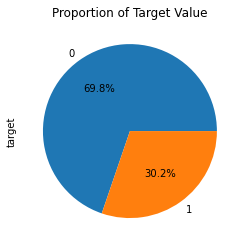

In [68]:
# Pie chart
plt.figure(figsize=(5,4))
email_df.target.value_counts().plot.pie(autopct = "%.1f%%")
plt.title("Proportion of Target Value")
plt.show()

In [69]:
email_df['Attachments'].value_counts()

0    9374
1     598
Name: Attachments, dtype: int64

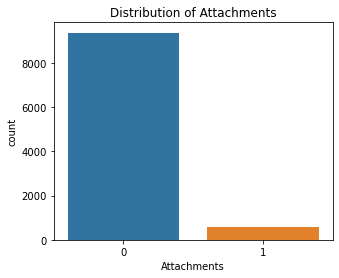

In [70]:
plt.figure(figsize=(5,4))
sns.countplot(x ="Attachments", data = email_df)
plt.title("Distribution of Attachments")
plt.show()

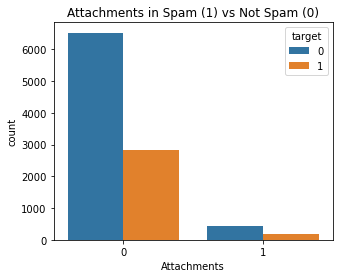

In [71]:
plt.figure(figsize=(5,4))
sns.countplot(x ="Attachments", hue = "target", data = email_df)
plt.title("Attachments in Spam (1) vs Not Spam (0)")
plt.show()

In [66]:
#new_vectors = hstack((new_vectors,np.array(email_attachment)[:,None]))
#new_vectors = hstack((new_vectors,np.array(is_test_data)[:,None]))

In [72]:
new_vectors

<9972x126393 sparse matrix of type '<class 'numpy.float64'>'
	with 1261513 stored elements in Compressed Sparse Row format>

In [60]:
new_vectors

<9972x126395 sparse matrix of type '<class 'numpy.float64'>'
	with 1262353 stored elements in COOrdinate format>

In [73]:
import scipy.sparse

df_from_mat = pd.DataFrame.sparse.from_spmatrix(new_vectors)

In [77]:
df_from_mat = pd.concat([df_from_mat,pd.Series(email_attachment)],axis=1,ignore_index = True)

In [83]:
df_from_mat

,0,1,2,3,4,5,6,7,8,9,...,126385,126386,126387,126388,126389,126390,126391,126392,126393,126394
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3,0.000000,0.001995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9967,0.000000,0.126080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
9968,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
9969,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
9970,0.036586,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [79]:
df_from_mat = pd.concat([df_from_mat,pd.Series(is_test_data)],axis=1,ignore_index = True)

In [ ]:
traindf = pd.DataFrame()
testdf = pd.DataFrame()
for index, row in df_from_mat.iterrows():
    if row.iat[-1] == 0:
        traindf = traindf.append(row)
    else:
        testdf = testdf.append(row)


In [112]:
traindf

""


In [101]:
df_from_mat.iloc[:,-1:]

,126394
0,1
1,1
2,1
3,1
4,1
...,...
9967,0
9968,0
9969,0
9970,0


In [44]:
test_spam

,data,target,Attachments,istestdata,data_new
1786,,1,0,0,
1763,Online Credit Breakthrough = ; Repair Your Cre...,1,0,0,online credit breakthrough = ; repair your cre...
2437,"Hello, jm@netnoteinc.comHuman Growth Hormone ...",1,0,0,"hello, jm@netnoteinc.comhuman growth hormone ..."
303,Toy ABC's Good Morning America ranks it t...,1,1,0,toy abc's good morning america ranks it t...
2083,"creditfix = Thank You, Y...",1,0,0,"creditfix = thank you, y..."
...,...,...,...,...,...
2375,>>From the Desk of Mr. Kenneth Uba\n \nUnion B...,1,0,0,>>from the desk of mr. kenneth uba\n \nunion b...
1986,Digital Authoring Tools : Featured Product Al...,1,0,0,digital authoring tools : featured product al...
612,Untitled Would you like to advertise your w...,1,0,0,untitled would you like to advertise your w...
710,"[Du suchst ein Sexabenteuer, Seitensprung, One...",1,1,0,"['du suchst ein sexabenteuer, seitensprung, on..."


In [39]:
len(test_spam.index)

200

In [41]:
new_vectors[1]

TypeError: 'coo_matrix' object is not subscriptable

### Clustering

#### KMeans Clustering

K-means clustering is a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity

KMeans Clustering with default parameters

In [ ]:
wcss = []
score = []
K = range(2,30)
for k in K:
    km = KMeans(n_clusters=k, random_state=1234, init = 'k-means++')
    km = km.fit(new_vectors)
    labels = km.predict(new_vectors) 
    wcss.append(km.inertia_)
    sc = silhouette_score(new_vectors, labels)
    score.append(sc)

plt.rcParams['figure.figsize'] = (15, 5)
#plt.subplot(1,1,1)
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('Within-Cluster-Sum-of-Squares')
plt.title('Elbow Method For Optimal k')


In [ ]:
email_df["clusterid"] = km.labels_



In [ ]:
len(email_df["clusterid"].unique())

In [ ]:
np.unique(km.labels_)

#### Visualize Clusters

We will use a technique called t-SNE (t-distributed Stochastic Neighbor Embedding) to generate a 2 dimensional representation of our dataset, in order to have a more intuitive understanding of how the clustering looks.

First let's look at an un-clustered version of this 2D projection.

In [ ]:
%%time
from sklearn.manifold import TSNE
import sklearn.cluster as cluster
newdims = (12, 8)
plt.subplots(1, 1, figsize=newdims)
plt.subplot(1, 1, 1)
plot_kwds = {'alpha' : 0.25, 's' : 40, 'linewidths':0}
projection = TSNE().fit_transform(new_vectors)
plt.scatter(*projection.T, **plot_kwds)
plt.show()

Now look at clustered version of this 2D projection with various clustering techniques

In [ ]:
%%time
import seaborn as sns

# This function will run a given clustering algorithm and plot the clusters on the same 2D  TSNE projection as above
def plot_clusters(data, algorithm, args, kwds):
    print(*args)
    labels = algorithm(*args, **kwds).fit_predict(data)
    palette = sns.color_palette('muted', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (.5, .5, .5) for x in labels]
    plt.scatter(*projection.T, s=50, linewidth=0, c=colors, alpha=0.25)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=14)

In [ ]:
# plot the clusters
newdims = (10, 8)
plt.subplots(1, 1, figsize=newdims)
plt.subplot(1, 1, 1)
plot_clusters(new_vectors, cluster.KMeans, (), {'n_clusters':11})

#### Word Cloud

In [ ]:
# word cloud with best K
best_k = 11
km = KMeans(n_clusters=best_k, init = 'k-means++')
km = km.fit(new_vectors)
labels = km.predict(new_vectors)
    
clusters = list(labels)

kmeans_result={'cluster':clusters,'reviews':email_df.data_new}
kmeans_result=pd.DataFrame(kmeans_result)
for k in range(0,best_k):
   s=kmeans_result[kmeans_result.cluster==k]
   text=s['reviews'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

In [ ]:
email_df["clusterid"] = kmeans_result["cluster"]

In [ ]:
email_df["clusterid"]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#read data from csv file

#create count plot for room types
%matplotlib inline
sns.set(style="darkgrid")
ax = sns.countplot(x='clusterid', hue="target", data=email_df)
plt.show()


### Naive Bayes Classification

It is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.

In [ ]:
email_df

## Test Data

In [ ]:
%%time


#TEST DATA


data_path = "/Users/ravis/Downloads/apruvspam"
# get all sub folders
sub_folders = [x[0] for x in os.walk(data_path) if x[0] != data_path]

                   
# read all emails from all sub folders
mail_ty = []
text_ty = []
data = []
target = []
email_attachment = []
attachment = False

for folder in sub_folders:
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    for file in files:
        with open(f"{folder}/{file}", encoding="latin1") as f:
            #    with open(f"{folder}/{file}","r") as f:
            x = email.message_from_file(f)
          #  print(x)
    #    if (file != 'cmds'): 
    #        mail_data.append(lines)
            
        mail_type = x.get_content_type()
        text_type = x.get_content_charset()
        mail_ty.append(mail_type)
        text_ty.append(text_type)
        if re.search("spam", folder):
            target.append(1)
        else:
             target.append(0)
                               
        if mail_type == "text/html":
            if not (isinstance(x.get_payload(), str)) and x.get_payload().get('Content-Disposition'):
                dispositions = x.get_payload().get("Content-Disposition", None).strip().split(";")
                if bool(dispositions[0].lower() == "attachment"):
                    attachment = True
                else:
                    attachment = False
          
            tmp = BeautifulSoup(x.get_payload(), 'html.parser')
            tmp = tmp.text.replace("\n", " ")
            data.append(tmp)
        elif "multipart" in mail_type:
            attachment = False
            multipart_data = []
            for text in x.get_payload():                        
                if not isinstance(text, str): 
                    if text.get('Content-Disposition'):
                        dispositions = text.get("Content-Disposition", None).strip().split(";")
                        if bool(dispositions[0].lower() == "attachment"):
                            attachment = True
                            
                    if text.get_content_type() == "text/html":
                        tmp = BeautifulSoup(text.get_payload(), 'html.parser')
                        tmp = tmp.text.replace("\n", " ")
                        multipart_data.append(tmp)
                    elif text.get_content_type() == "text/plain":
                        multipart_data.append(text.get_payload()) 
                
            multipart_email = [''.join(str(item)) for item in multipart_data]
            data.append(multipart_email)
        else:
            if not (isinstance(x.get_payload(), str)) and x.get_payload().get('Content-Disposition'):
                dispositions = x.get_payload().get("Content-Disposition", None).strip().split(";")
                if bool(dispositions[0].lower() == "attachment"):
                    attachment = True
                else:
                    attachment = False
            data.append(x.get_payload()) 
            
        if attachment:
            email_attachment.append(1)
        else:
            email_attachment.append(0)
            
            
df = pd.DataFrame()

df["mail_types"] = mail_ty
df["text_types"] = text_ty

df["mail_types"].value_counts()
# Create a data frame with email text and target (whether mail is spam or not, 1 for spam and 0 for not a spam)
test_email_df = pd.DataFrame()
test_email_df["data"] = data
#email_df["mail_type"] = mail_ty
#email_df["text_type"] = text_ty
test_email_df["target"] = target
test_email_df["Attachments"] = email_attachment

          



In [ ]:
test_email_df["data_new"] = [''.join(str(item).lower()) for item in test_email_df.data]
test_vectors = tf_vectorizer.fit_transform(test_email_df.data_new)

In [ ]:
test_km = km.predict(test_vectors)

In [ ]:
def displayModel_metrics(best_model, grid_model, features, target, cv):
    metrics = cross_validate(best_model, features, y=target, cv=cv, 
                             scoring=['accuracy','precision','recall'], return_train_score=True) 
    
    y_predict = cross_val_predict(best_model, features, target, cv=cv)

    print('\nBest Accuracy with Grid Search            : {:.3f}'.format(grid_model.best_score_))
    print('\nTraining data Metrics')
    print('\n     The average accuraccy : {:.3f}'.format(metrics['train_accuracy'].mean()))
    print('     The average precision : {:.3f}'.format(metrics['train_precision'].mean()))
    print('     The average recall    : {:.3f}'.format(metrics['train_recall'].mean()))

    print('\nTest data Metrics')
    print('\n     The average accuracy  : {:.3f}'.format(metrics['test_accuracy'].mean()))
    print('     The average precision : {:.3f}'.format(metrics['test_precision'].mean()))
    print('     The average  recall   : {:.3f}'.format(metrics['test_recall'].mean()))
    
    matrix = classification_report(target, y_predict, labels=[1,0])
    print('\nClassification report\n')
    print(matrix)

    
    
# Reference https://github.com/jakemdrew/DataMiningNotebooks/blob/master/06.%20Classification.ipynb
# ROC curve plot
def roc_curve_plot(model_fit, features, target):

    sns.set_palette("dark")

    yhat_score = model_fit.predict_proba(features)

    # Compute ROC curve for a subset of interesting classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in np.unique(target):
        fpr[i], tpr[i], _ = mt.roc_curve(target, yhat_score[:, i], pos_label=i)
        roc_auc[i] = mt.auc(fpr[i], tpr[i])

    for i in np.unique(target):
        plt.plot(fpr[i], tpr[i], label= ('class %d (area = %0.2f)' % (i, roc_auc[i])))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.legend(loc="lower right")  
    plt.title('Receiver operating characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [ ]:
#Create Cross Validation Procedure
cv = StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)

In [ ]:
# Naive Bayes (NB) classifier 
clf = MultinomialNB().fit(new_vectors,email_df['target'])

In [ ]:
# define parameters
C_nb = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]  
nb_prior=[True, False]

nb_clf = MultinomialNB()
# define grid search
param_grid_nb = dict(alpha=C_nb, fit_prior=nb_prior)

grid_search_nb = GridSearchCV(estimator=nb_clf, param_grid=param_grid_nb, n_jobs=-1, cv=cv, 
                              scoring='accuracy',error_score=0)

In [ ]:
%%time
grid_result_nb = grid_search_nb.fit(new_vectors,email_df['target'])
# summarize results
print("Best: %f using %s" % (grid_result_nb.best_score_, grid_result_nb.best_params_))
means = grid_result_nb.cv_results_['mean_test_score']
stds = grid_result_nb.cv_results_['std_test_score']
params = grid_result_nb.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_nb =grid_result_nb.best_estimator_
best_Estimator_nb

In [ ]:
# Display model metrics
displayModel_metrics(best_Estimator_nb, grid_result_nb, new_vectors,email_df['target'], cv)

In [ ]:
# Plot ROC curve
roc_curve_plot(grid_result_nb, new_vectors, email_df['target'])

### Naive Bayes Classification with clusters as feature

In [ ]:
# add clusters as feature
new_vectors = hstack((new_vectors,np.array(clusters)[:,None]))

In [ ]:
new_vectors

In [ ]:
%%time
grid_result_nb = grid_search_nb.fit(new_vectors,email_df['target'])
# summarize results
print("Best: %f using %s" % (grid_result_nb.best_score_, grid_result_nb.best_params_))
means = grid_result_nb.cv_results_['mean_test_score']
stds = grid_result_nb.cv_results_['std_test_score']
params = grid_result_nb.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_nb =grid_result_nb.best_estimator_
best_Estimator_nb

In [ ]:
# Display model metrics
displayModel_metrics(best_Estimator_nb, grid_result_nb, new_vectors,email_df['target'], cv)

In [ ]:
# Plot ROC curve
roc_curve_plot(grid_result_nb, new_vectors, email_df['target'])

### Feature importance with Logistic regression 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()

# define parameters
penalty_LR = ['l1', 'l2', 'elasticnet', 'none'] 
#penalty_LR = [ 'l1', 'l2'] 
C_LR = [0.001, 0.01, 0.1, 1, 10, 100, 1000]  
#C_LR = [0.001,10, 100]  
max_iter_LR = [500]
#max_iter_LR = [500]
class_weight_LR = ['balanced']
#solver_LR = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
solver_LR = ['lbfgs', 'liblinear']

# define grid search
param_grid_LR = dict(penalty=penalty_LR, C=C_LR, max_iter=max_iter_LR, class_weight=class_weight_LR, solver=solver_LR)

grid_search_LR = GridSearchCV(estimator=LR, param_grid=param_grid_LR, n_jobs=-1, cv=cv, 
                              scoring='accuracy',error_score=0)

In [ ]:
%%time
grid_result_LR = grid_search_LR.fit(new_vectors,email_df['target'])
# summarize results
print("Best: %f using %s" % (grid_result_LR.best_score_, grid_result_LR.best_params_))
means = grid_result_LR.cv_results_['mean_test_score']
stds = grid_result_LR.cv_results_['std_test_score']
params = grid_result_LR.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_LR =grid_result_LR.best_estimator_
best_Estimator_LR

In [ ]:
best_Estimator_LR.coef_[0]

In [ ]:
features = tf_vectorizer.get_feature_names()
features.append('email_attachment')
features.append('clusters')

feature_importance_df = pd.DataFrame(features, columns=['features'])
feature_importance_df['feature_coef'] = best_Estimator_LR.coef_[0]

feature_importance_df.head()
feature_importance_df = feature_importance_df.sort_values(by=['feature_coef'])

In [ ]:
feature_importance_df.shape

In [ ]:
feature_importance_df.tail(20)

In [ ]:
feature_importance_df.head(20)